# Model Configuration - 42 School Pass/Fail Prediction






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import requests
import json
import csv
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

## 0. Collecting data and Merge Data

### 0-1. Calling API

Please refer to the "Calling API Repository"

By calling /v2/campus/:/campus_id/users, we could separately collect raw data for all users of Seoul 42 Campus and Ecole 42 Campus, and the campus_ids for each are 29 and 1.

By calling /v2/users/:user_id/scale_teams/as_corrector and /v2/users/:user_id/scale_teams/as_corrected, 
we were able to obtain data in json format with items for events in which a user participated as a correcter and correction recipient.

By counting item named with corrcected, we've figured out how many evaluations they gave (corrector) and feedback they received(corrected).

### 0-2. Crawling

Please refer to the "Crawling Repository"

We collected 'PASS, Highest C Piscine, Final exam score, Number of group assignments, level, penalty' 

Data is collected through crawling by accessing each user's page.

Level: Overall progress that can be made through assignments, and midterm exams

Group Assignments: Optional group assignments

Penalty: How many times you cheated; each time a user get caught, 42 points will be deducted from assignment score

Highest C-picsine: In assignments using the C language, the highest level of assignment completed (0~13)

Final Exam Score: as it is.

## 1. Preprocessing
### 1-1. Load the data

In [2]:
data = pd.read_csv('/Users/kimkangmin/data_set_42seoul.csv')
data

,correcteds,correctors,created_at,PASS,Highest C Piscine,Final exam score,Number of group assignments,level,penalty
0,2,6,10,0,0,NaN,0,0.00,0
1,14,0,10,0,0,NaN,0,0.00,0
2,2,7,10,0,0,NaN,1,1.19,0
3,40,26,10,0,4,NaN,3,5.34,0
4,0,0,10,0,0,NaN,0,0.00,0
...,...,...,...,...,...,...,...,...,...
4318,92,96,2,1,11,66.0,3,9.84,0
4319,56,66,2,1,9,66.0,4,7.92,0
4320,67,80,2,1,9,54.0,3,8.85,0
4321,103,120,2,1,11,100.0,4,12.94,0


### 1-2. drop the data points whose final exam score is under 42.

In [3]:
data = data[data['Final exam score'] >= 42]
data.shape

(2911, 9)

### 1-3. EDA

### Pair Plot

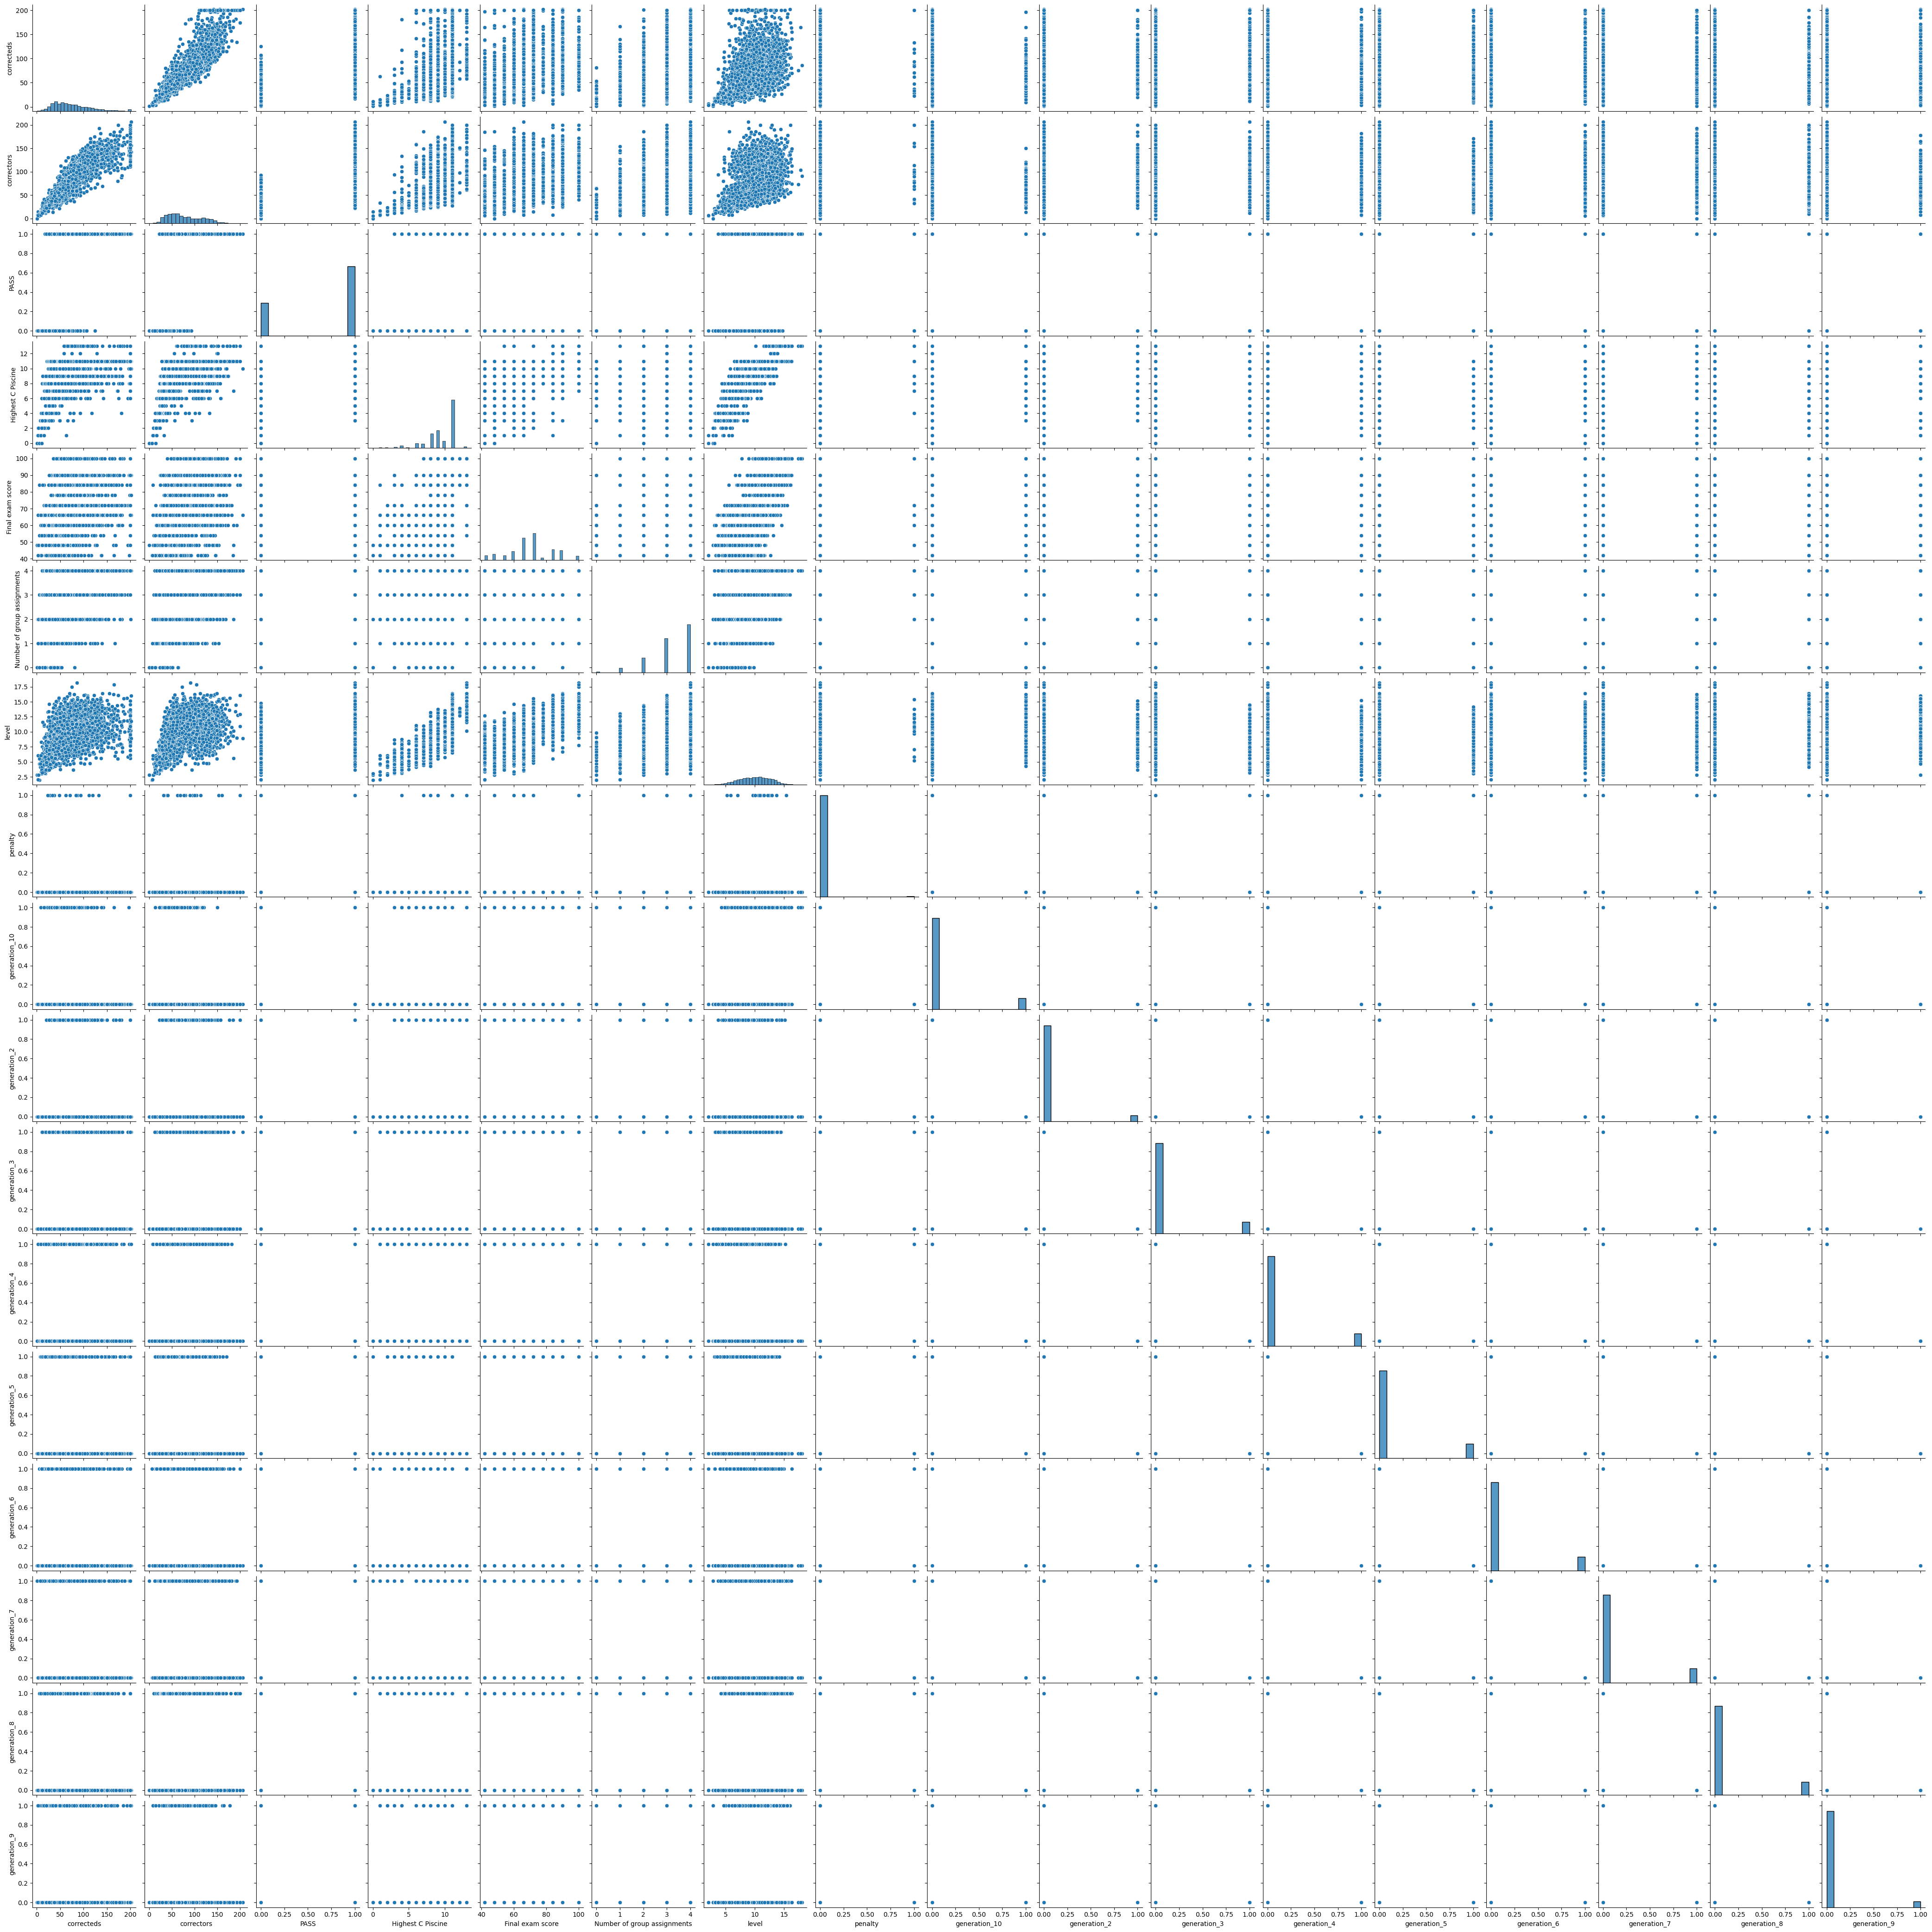

In [14]:
import seaborn as sns
sns.pairplot(data)
plt.show()

### Correlation Matrix

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11))
X_corr = X.corr()

# mask
mask = np.triu(np.ones_like(X_corr, dtype=bool))

# adjust mask and df
mask = mask[:, :]
corr = X_corr.iloc[:,:].copy()

# color map (RdBu_r 사용)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# 또는 다른 색상 맵을 사용할 수도 있습니다
# cmap = 'coolwarm'

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
            linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
            cbar_kws={"shrink": .8}, square=True)

# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# title
title = 'CORRELATION MATRIX\n'
plt.title(title, loc='left', fontsize=15)
plt.show()

### 1-4. Apply one-hot encoding for splitting generation

In [4]:
data_encoded = pd.get_dummies(data['created_at'].astype(str), prefix='generation')

data = pd.concat([data, data_encoded], axis=1)

data = data.drop('created_at', axis=1)

data

,correcteds,correctors,PASS,Highest C Piscine,Final exam score,Number of group assignments,level,penalty,generation_10,generation_2,generation_3,generation_4,generation_5,generation_6,generation_7,generation_8,generation_9
5,81,65,0,8,54.0,0,5.98,0,1,0,0,0,0,0,0,0,0
6,103,116,1,11,72.0,3,12.60,0,1,0,0,0,0,0,0,0,0
8,54,68,0,9,60.0,3,8.88,0,1,0,0,0,0,0,0,0,0
13,32,41,0,6,60.0,4,6.17,0,1,0,0,0,0,0,0,0,0
18,84,86,1,11,66.0,3,12.24,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,92,96,1,11,66.0,3,9.84,0,0,1,0,0,0,0,0,0,0
4319,56,66,1,9,66.0,4,7.92,0,0,1,0,0,0,0,0,0,0
4320,67,80,1,9,54.0,3,8.85,0,0,1,0,0,0,0,0,0,0
4321,103,120,1,11,100.0,4,12.94,0,0,1,0,0,0,0,0,0,0


### 1-5. Split the data into train set and test set

In [5]:
X = data.drop('PASS', axis = 1)
y = data['PASS']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

## 2. Data Mining with Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the pipeline with imbalanced-learn
pipe = ImbPipeline([
    ('preprocessing', None),
    ('sampler', None),  # Added for oversampling/undersampling
    ('classifier', None)
])
hyperparam_grid = [
    {
        'preprocessing': [StandardScaler(), MinMaxScaler(), None],
        'classifier': [LogisticRegression(max_iter=10000)],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    },
    {
        'preprocessing': [None],
        'classifier': [RandomForestClassifier()],
        'classifier__max_features': [1, 2, 3, 4, 5],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    },{
        'preprocessing': [StandardScaler(), MinMaxScaler(), None],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1, 3, 5, 10, 15],
        'classifier__metric': ['minkowski', 'euclidean', 'mahalanobis'],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    }
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(pipe, hyperparam_grid, scoring='roc_auc', refit=True, cv=kfold)
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best Training score: {grid_search.best_score_}")
print(f"Test-set score: {grid_search.score(X_test, y_test)}")

/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During han

/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During han

/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During han

/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 46, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During han

Best hyperparameters: {'classifier': LogisticRegression(C=10, max_iter=1000), 'classifier__C': 10, 'classifier__penalty': 'l2', 'preprocessing': None, 'sampler': None}
Best cross-validation score: 0.9783622091050125
Test-set score: 0.9856811407668338


/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3. Post-Processing

### 3-1. ROC Curve

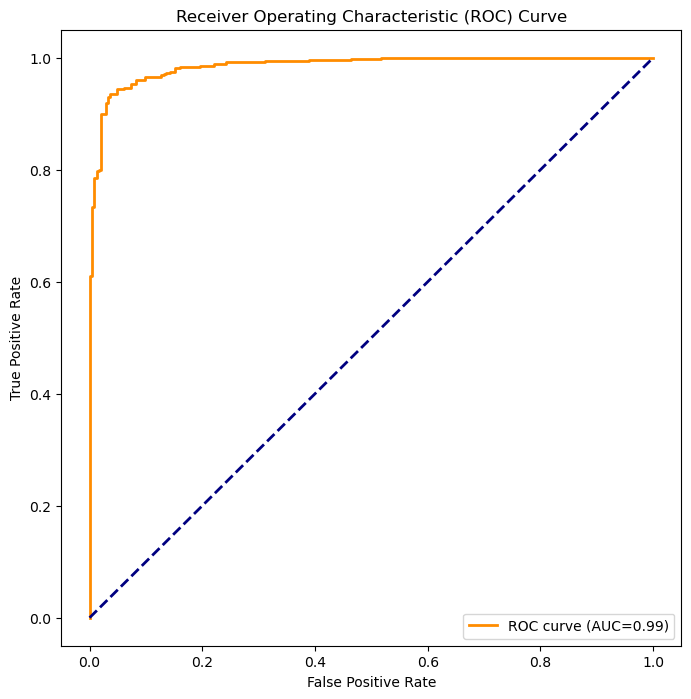

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 최적 모델 예측 확률 구하기
y_prob = grid_search.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# AUC(Area Under the Curve) 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


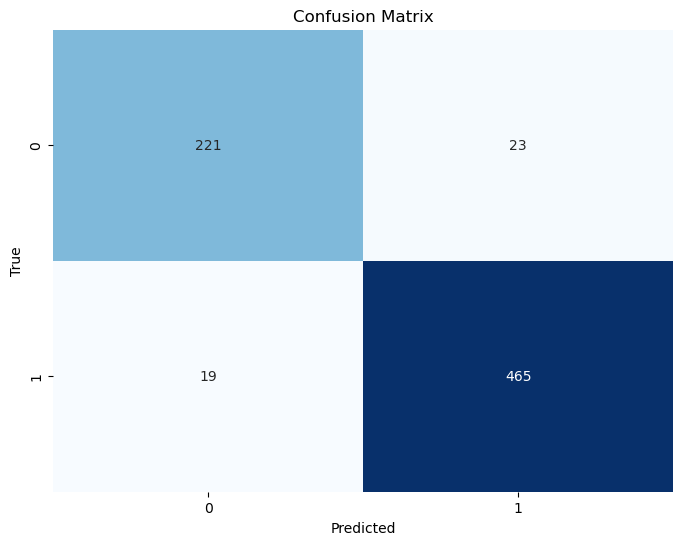

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
best_classifier = grid_search.best_estimator_.named_steps['classifier']

if isinstance(best_classifier, LogisticRegression):
    # For Logistic Regression, retrieve coefficients as feature importances
    coefficients = best_classifier.coef_[0]
    feature_importances = abs(coefficients)  # Use absolute values for importance
    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    importance_dict = dict(zip(feature_names, feature_importances))
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    print("Feature Importances (Logistic Regression):")
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance}")

elif isinstance(best_classifier, RandomForestClassifier) or isinstance(best_classifier, KNeighborsClassifier):
    # For Random Forest or KNN, retrieve feature importances directly
    feature_importances = best_classifier.feature_importances_
    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    importance_dict = dict(zip(feature_names, feature_importances))
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"Feature Importances ({type(best_classifier).__name__}):")

Feature Importances (Logistic Regression):
generation_2: 5.641992153089556
generation_9: 4.6487632324881005
generation_3: 4.172221074668422
generation_8: 2.6472143892609514
generation_10: 2.309521219856303
generation_5: 2.0126628040448717
generation_7: 1.8523321322861703
penalty: 0.888703799742319
generation_6: 0.8196263346677639
level: 0.8119214121319569
Highest C Piscine: 0.4947060397463301
generation_4: 0.15058658076463768
correctors: 0.10681054608576711
Final exam score: 0.06539251255854964
Number of group assignments: 0.04468388055736804
correcteds: 0.019465477017131767
